<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_13/S13_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Connect Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Install packages

In [3]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull
#!cd ../
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git -C dl_hub pull
!git pull
#!cd ../

!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torchsummary"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

Cloning into 'ERA_V1'...
remote: Enumerating objects: 1205, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 1205 (delta 159), reused 317 (delta 125), pack-reused 821
Receiving objects: 100% (1205/1205), 185.68 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (604/604), done.
Already up to date.
Cloning into 'dl_hub'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 402 (delta 102), reused 7 (delta 2), pack-reused 248
Receiving objects: 100% (402/402), 106.60 KiB | 9.69 MiB/s, done.
Resolving deltas: 100% (246/246), done.
Already up to date.
fatal: not a git repository (or any of the parent directories): .git
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30

In [4]:
import sys
sys.path.append("ERA_V1/session_13")
sys.path.append("dl_hub")

In [5]:
!git -C dl_hub pull


Already up to date.


In [6]:
import dl_hub.YOLO_V3.config as config
import torch
import torch.optim as optim
import os
from dl_hub.YOLO_V3.model import YOLOv3
from tqdm import tqdm
from dl_hub.YOLO_V3.yolo_v3_utils.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from dl_hub.YOLO_V3.yolo_v3_utils.loss import YoloLoss
from dl_hub.YOLO_V3.PL_model import LitYOLOv3
from dl_hub.YOLO_V3.yolo_v3_utils.PL_data_module import YOLODataModule
from dl_hub.PL_main import train_and_eval_pl_model
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [7]:
print(config.DATASET)


/content/gdrive/MyDrive/Datasets/PASCAL_VOC_SMALL


**Define Data Module**

In [8]:
# Define data module
#csv_files = [os.path.join(config.DATASET, "100examples.csv"),os.path.join(config.DATASET,"8examples.csv")]
csv_files = [os.path.join(config.DATASET, "train.csv"),os.path.join(config.DATASET,"test.csv")]
train_transforms=config.train_transforms
test_transforms=config.test_transforms
val_transforms = test_transforms
IMAGE_SIZE = config.IMAGE_SIZE
S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
img_dir=config.IMG_DIR
label_dir=config.LABEL_DIR
anchors=config.ANCHORS
batch_size = 8
yolo_dm = YOLODataModule(
    csv_files,
    img_dir,
    label_dir,
    anchors,
    batch_size,
    image_size=IMAGE_SIZE,
    S=S,
    C=20,
    train_transforms = train_transforms,
    val_transforms = val_transforms,
    test_transforms = test_transforms,
    val_split=0.1,
    num_workers = config.NUM_WORKERS,
    use_mosaic_on_train=True,
    mosaic_probability=0.75,
    pin_memory = False)
yolo_dm.prepare_data()
yolo_dm.setup()

**Identify best LR**

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.87E-02


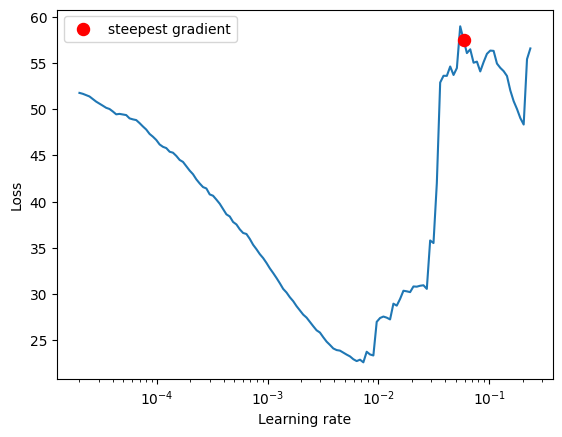

In [ ]:
from torch_lr_finder import LRFinder

# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5

# Define Model
dummy_yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(dummy_yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
train_data_loader = yolo_dm.train_dataloader()

def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(dummy_yolo_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_data_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
max_lr = 8E-4

**Load trained model**

In [9]:
model_path = "/content/gdrive/MyDrive/trained_models/YOLOv3/75_mosaic_checkpoint_epoch_39_step_74480.ckpt"

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
train_data_loader = yolo_dm.train_dataloader()
test_data_loader = yolo_dm.test_dataloader()
# Define Model
yolo_model_trained = LitYOLOv3.load_from_checkpoint(model_path)


**Define the targets for GradCAM**

In [282]:
import torchvision
from dl_hub.YOLO_V3.yolo_v3_utils.utils import non_max_suppression, plot_image
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import cv2
import numpy as np

# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(config.PASCAL_CLASSES), 3))

class YOLOv3Target:
    pass

def get_box_coords(box, im):
    height, width, _ = im.shape
    upper_left_x = int((box[0] - box[2] / 2)*width)
    upper_left_y = int((box[1] - box[3] / 2)*height)
    lower_right_x = upper_left_x + int(box[2]*width)
    lower_right_y = upper_left_y + int(box[3]*height)
    return [upper_left_x, upper_left_y, lower_right_x, lower_right_y]


def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image


def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam, labels, classes):
    """Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    box_coords = []
    for box in boxes:
        [x1,y1,x2,y2] = get_box_coords(box[2:],image_float_np)
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        images.append(img)
        box_coords.append([x1,y1,x2,y2])
    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    img = Image.fromarray(draw_boxes(box_coords,labels,classes,eigencam_image_renormalized))
    return img


def export_image_with_bounding_box(boxes, image_float_np, labels, classes):
    box_coords = []
    for box in boxes:
        [x1,y1,x2,y2] = get_box_coords(box[2:],image_float_np)
        box_coords.append([x1,y1,x2,y2])
    img_cv = cv2.cvtColor(np.uint8(image_float_np*255), cv2.COLOR_BGR2RGB)
    img = Image.fromarray(draw_boxes(box_coords,labels,classes,img_cv))
    return img


In [285]:
import numpy as np
import matplotlib.pyplot as plt


def get_labels(boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = config.COCO_LABELS if config.DATASET=='COCO' else config.PASCAL_CLASSES
    all_class_names = []
    all_class_labels = []
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        class_name = class_labels[int(class_pred)]
        all_class_names.append(class_name)
        class_label = int(class_pred)
        all_class_labels.append(class_label)
    return all_class_names, all_class_labels


def predict(model, loader, anchors, device, thresh=0.6, iou_thresh=0.5):
    model.eval()
    x, y = next(iter(loader))
    num_images = x.shape[0]
    x = x.to(device)
    global_height, global_width = x.shape[-2:]
    boxes_list = []
    classes_list = []
    labels_list = []
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box
    for i in range(num_images):
        nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        classes, labels = get_labels(nms_boxes)
        boxes_list.append(nms_boxes)
        classes_list.append(classes)
        labels_list.append(labels)
    x_np_float_array = np.asarray(x.cpu())
    return x, x_np_float_array, boxes_list, classes_list, labels_list


In [286]:
# Target layer for lowest scale prediction: yolo_model_trained.model.layers[-1].pred[0]
# Target layer for 2nd lowest scale prediction: yolo_model_trained.model.layers[22].pred[0]
# Target layer for highest scale prediction: yolo_model_trained.model.layers[15].pred[0]
target_layers = [yolo_model_trained.model.layers[15].pred[0]]
targets = [YOLOv3Target()]
cam = EigenCAM(yolo_model_trained,
               target_layers,
               use_cuda=torch.cuda.is_available(),
               reshape_transform=None)
input_tensor, image_float_np, boxes, classes, labels = predict(yolo_model_trained,
                                                               test_data_loader,
                                                               scaled_anchors,
                                                               device = config.DEVICE)
grayscale_cam = cam(input_tensor, targets=targets)


In [287]:
for cnt in range(input_tensor.shape[0]):
    img = renormalize_cam_in_bounding_boxes(boxes[cnt], image_float_np[cnt].squeeze().transpose((1,2,0)), grayscale_cam[cnt].squeeze().T, labels[cnt], classes[cnt])
    #img = export_image_with_bounding_box(boxes[cnt], image_float_np[cnt].squeeze().transpose((1,2,0)), labels[cnt], classes[cnt])
    img.save(f'test2_{cnt}.png')


[[18.0, 0.7400769591331482, 0.5119374394416809, 0.4896511137485504, 0.16287033259868622, 0.20359116792678833]]


In [23]:
import torchinfo

def model_summary(model, input_size):
    torchinfo.summary(model,
                      input_size = input_size,
                      batch_dim=0,
                      col_names=("kernel_size",
                                 "input_size",
                                 "output_size",
                                 "num_params",
                                 "mult_adds"),
                       verbose=1,)

model_summary(yolo_model_trained, (3, 416, 416))

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitYOLOv3                                               --                        [1, 3, 416, 416]          [1, 3, 13, 13, 25]        --                        --
├─YOLOv3: 1-1                                           --                        --                        --                        --                        --
│    └─ModuleList: 2-1                                  --                        --                        --                        --                        --
│    │    └─CNNBlock: 3-1                               --                        [1, 3, 416, 416]          [1, 32, 416, 416]         928                       149,520,448
│    │    └─CNNBlock: 3-2                               --                        [1, 32, 416, 416]         [1, 64, 208, 208]         18,560                    797,442,1